In [1]:
from fourlang.text_to_4lang import TextTo4lang
from fourlang.lexicon import Lexicon
from graphviz import Source
from scripts.parse_data import read_sherliic, build_graph
from scripts.similarity import Similarity

from tqdm import tqdm
preds = []
text_to_4lang = TextTo4lang(lang="en")
data = read_sherliic("data/dev.csv", ud_path="data/relation_index.tsv", keep_context=True)
data_frame = build_graph(data)

lexicon = Lexicon(lang="en")

similarity = Similarity(with_embedding=False)

In [2]:
data['premise_text'] = data["prem_argleft"] + " " + data["premise"] + " " + data["prem_argright"]

In [3]:
data['hyp_text'] = data["hypo_argleft"] + " " + data["hypothesis"] + " " + data["hypo_argright"]

In [4]:
data

,prem_argleft,premise,prem_argright,hypo_argleft,hypothesis,hypo_argright,score,premise_ud,hypothesis_ud,premise_text,hyp_text
0,A,is nation in,B,A,is country in,B,1,nsubj^-___nation___prep___in___pobj,nsubj^-___country___prep___in___pobj,A is nation in B,A is country in B
1,B,hates,A,B,is being at war with,A,0,dobj^-___hate___nsubj,pobj^-___with___prep^-___war___pobj^-___at___p...,B hates A,B is being at war with A
2,B,is calling,A,B,is urging,A,0,dobj^-___call___nsubj,dobj^-___urge___nsubj,B is calling A,B is urging A
3,B,is displacing,A,A,is competing with,B,0,dobj^-___displace___nsubj,nsubj^-___compete___prep___with___pobj,B is displacing A,A is competing with B
4,A,decides to invade,B,A,is bombing,B,0,nsubj^-___decide___xcomp___invade___dobj,nsubj^-___bomb___dobj,A decides to invade B,A is bombing B
...,...,...,...,...,...,...,...,...,...,...,...
991,B,is being invaded by,A,A,is conquering,B,1,pobj^-___by___prep^-___invade___nsubjpass,nsubj^-___conquer___dobj,B is being invaded by A,A is conquering B
992,A,is committing in,B,A,is using against,B,0,nsubj^-___commit___prep___in___pobj,nsubj^-___use___prep___against___pobj,A is committing in B,A is using against B
993,B,is conducting in,A,B,is having,A,0,pobj^-___in___prep^-___conduct___nsubj,rcmod___have___nsubj,B is conducting in A,B is having A
994,B,is stopping,A,B,is forcing,A,1,dobj^-___stop___nsubj,dobj^-___force___nsubj,B is stopping A,B is forcing A


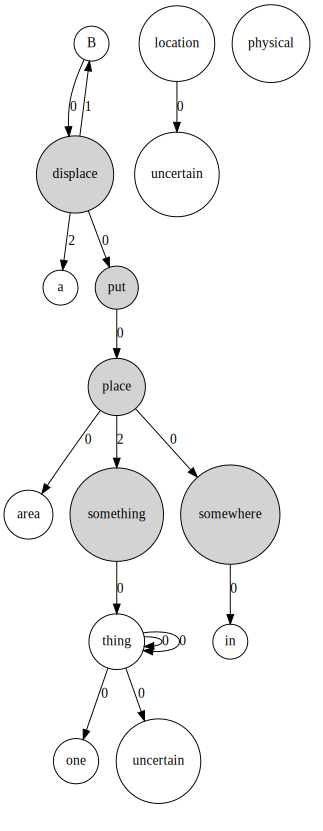

In [5]:
premise = text_to_4lang.process_text(data.iloc[3]["premise_text"], expand=True, depth=3)
dot_graph_premise = premise.to_dot()
Source(dot_graph_premise)

In [28]:
preds = []
for i in tqdm(range(len(data))):
    index = i
    premise = data["premise_text"][index]
    hypothesis = data["hyp_text"][index]
    score = data.score[index]
    graph_premise = text_to_4lang.process_text(premise, expand=True, depth=2, blacklist=["in", "on", "of", ])
    graph_hypothesis = text_to_4lang.process_text(hypothesis, expand=True, depth=1)
    pred = similarity.asim_jac_nodes(graph_premise, graph_hypothesis)
    if pred > 0.5:
        preds.append(1)
    else:
        preds.append(0)

100%|██████████| 996/996 [04:48<00:00,  3.13it/s]


In [29]:
from sklearn.metrics import precision_recall_fscore_support as pr
bPrecis, bRecall, bFscore, bSupport = pr(data_frame.score.tolist(), preds, average='binary')

print("Precision: " +  str(bPrecis))
print("Recall: " +  str(bRecall))
print("Fscore: " +  str(bFscore))

Precision: 0.6509433962264151
Recall: 0.2084592145015106
Fscore: 0.31578947368421056
